### Import libraries and data

Import the libaries

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier  # Need this to load the RF model

Import the data and the models

In [3]:
final_rf = pickle.load(open('final_rf_model.pkl', 'rb'))
X_train = pd.read_pickle('X_train.pkl')
y_train = np.load('y_train.npy', allow_pickle=True)

### Tree visualization

In this section we can observe the decision rules from a single tree within our random forest model:

- We can view the decision rules with a max depth of 2, as with a depth of 3 we already have problems visualizing it

- We can view the leaf nodes of the tree and the decisions made to get to it

- We will observe common root nodes and class distribution in leaves

- We will analyze the most common paths for each class

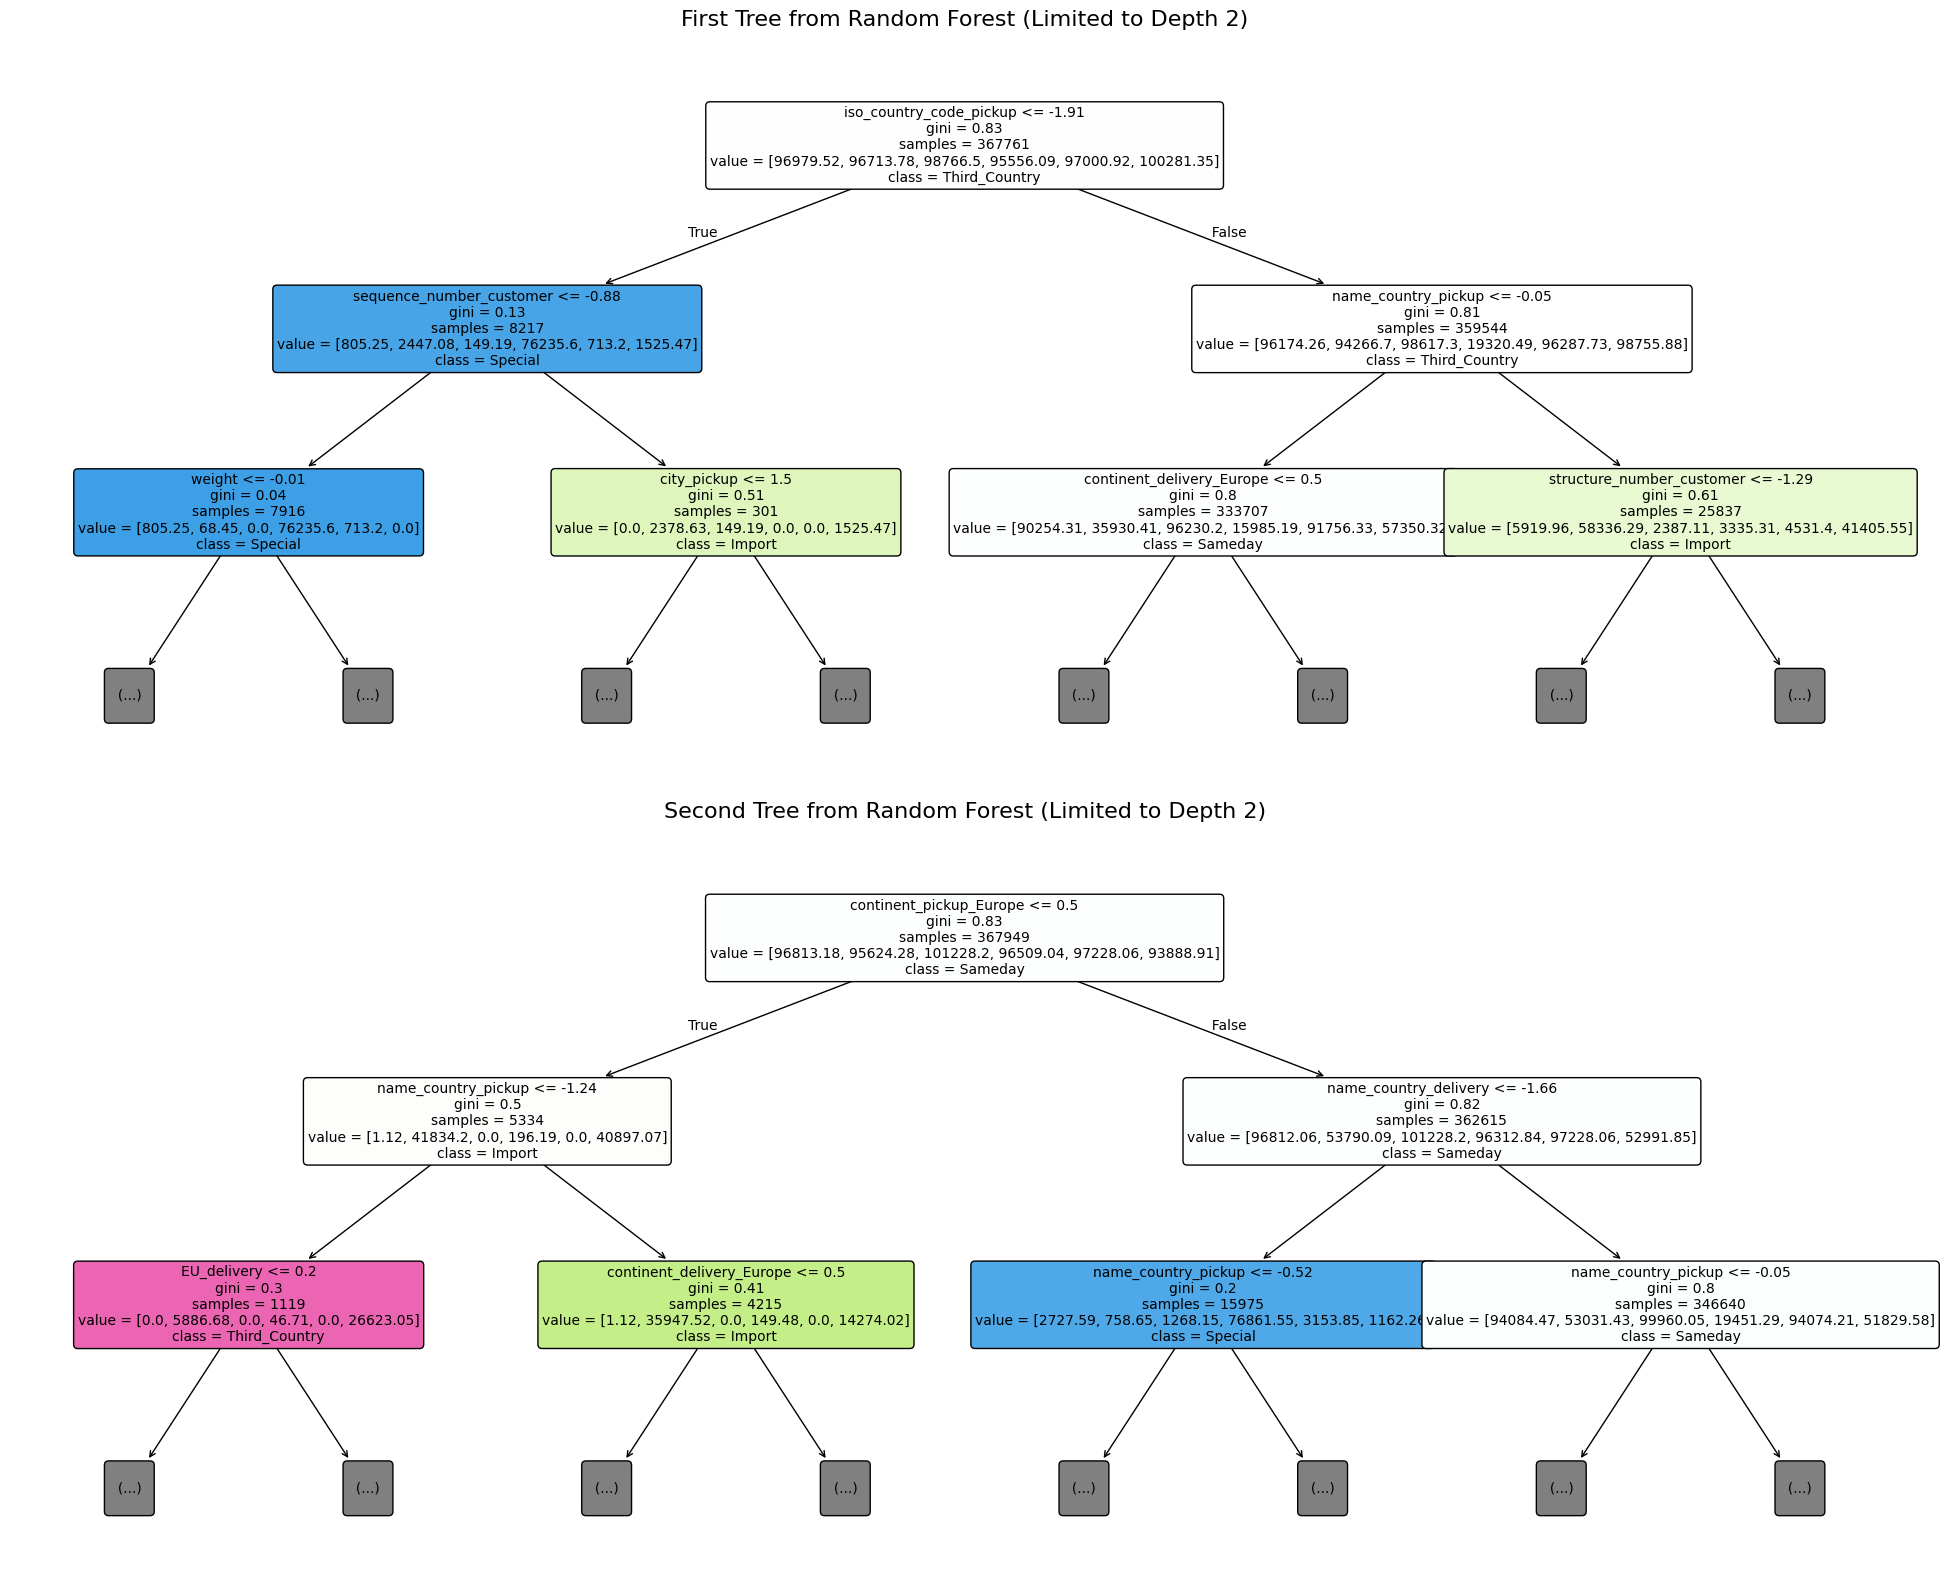


Decision Rules for First Tree:
--------------------------------------------------
Depth 1
If iso_country_code_pickup <= -1.91:
Depth 2
If sequence_number_customer <= -0.88:
If sequence_number_customer > -0.88:
------------------------------
If iso_country_code_pickup > -1.91:
Depth 2
If name_country_pickup <= -0.05:
If name_country_pickup > -0.05:
------------------------------
------------------------------

Decision Rules for Second Tree:
--------------------------------------------------
Depth 1
If continent_pickup_Europe <= 0.50:
Depth 2
If name_country_pickup <= -1.24:
If name_country_pickup > -1.24:
------------------------------
If continent_pickup_Europe > 0.50:
Depth 2
If name_country_delivery <= -1.66:
If name_country_delivery > -1.66:
------------------------------
------------------------------


In [9]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Analyze two trees from the random forest
tree1 = final_rf.estimators_[0]  # First tree
tree2 = final_rf.estimators_[1]  # Second tree
tree1_ = tree1.tree_
tree2_ = tree2.tree_

# Visualize both tree structures
plt.figure(figsize=(20, 16))

# Plot first tree
plt.subplot(2, 1, 1)
plot_tree(tree1,
          feature_names=X_train.columns,
          class_names=final_rf.classes_,
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=10,
          precision=2)
plt.title("First Tree from Random Forest (Limited to Depth 2)", fontsize=16, pad=20)

# Plot second tree
plt.subplot(2, 1, 2)
plot_tree(tree2,
          feature_names=X_train.columns,
          class_names=final_rf.classes_,
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=10,
          precision=2)
plt.title("Second Tree from Random Forest (Limited to Depth 2)", fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# Print decision rules for both trees
def print_rules(node, depth, path, tree_, X_train):
    if depth > 2:
        return

    if tree_.children_left[node] != tree_.children_right[node]:  # internal node
        name = X_train.columns[tree_.feature[node]]
        threshold_val = tree_.threshold[node]
        print("Depth", depth)
        print(f"If {name} <= {threshold_val:.2f}:")
        print_rules(tree_.children_left[node], depth + 1, path + [f"{name} <= {threshold_val:.2f}"], tree_, X_train)
        print(f"If {name} > {threshold_val:.2f}:")
        print_rules(tree_.children_right[node], depth + 1, path + [f"{name} > {threshold_val:.2f}"], tree_, X_train)
        print("-" * 30)

print("\nDecision Rules for First Tree:")
print("-" * 50)
print_rules(0, 1, [], tree1_, X_train)

print("\nDecision Rules for Second Tree:")
print("-" * 50)
print_rules(0, 1, [], tree2_, X_train)


In the next cell, we are going to look at 5 sample nodes from each tree, from root to leaf node.

In [5]:
# Function to print leaf nodes for a specific tree
def print_leaves(node, path, tree_, X_train, final_rf, leaves_printed):
    if leaves_printed[0] >= 5:
        return

    if tree_.feature[node] == -2:  # leaf node
        predicted_class = final_rf.classes_[np.argmax(tree_.value[node][0])]
        n_samples = tree_.n_node_samples[node]
        print(f"\nLeaf Node {leaves_printed[0] + 1}:")
        print(f"Decision Path: {' AND '.join(path)}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Number of samples in leaf: {n_samples}")
        print("-" * 50)
        leaves_printed[0] += 1
        return

    name = X_train.columns[tree_.feature[node]]
    threshold = tree_.threshold[node]

    print_leaves(tree_.children_left[node], path + [f"{name} <= {threshold:.2f}"], tree_, X_train, final_rf, leaves_printed)
    if leaves_printed[0] < 5:
        print_leaves(tree_.children_right[node], path + [f"{name} > {threshold:.2f}"], tree_, X_train, final_rf, leaves_printed)

# Print sample leaf nodes for both trees
print("\nSample of 5 Leaf Nodes from First Tree:")
print("=" * 50)
leaves_printed1 = [0]  # Using list to make it mutable
print_leaves(0, [], tree1_, X_train, final_rf, leaves_printed1)

print("\nSample of 5 Leaf Nodes from Second Tree:")
print("=" * 50)
leaves_printed2 = [0]  # Using list to make it mutable
print_leaves(0, [], tree2_, X_train, final_rf, leaves_printed2)


Sample of 5 Leaf Nodes from First Tree:

Leaf Node 1:
Decision Path: iso_country_code_pickup <= -1.91 AND sequence_number_customer <= -0.88 AND weight <= -0.01 AND sequence_number_customer <= -1.18 AND city_pickup <= -0.74 AND postal_code_delivery <= -0.55
Predicted Class: Import
Number of samples in leaf: 7
--------------------------------------------------

Leaf Node 2:
Decision Path: iso_country_code_pickup <= -1.91 AND sequence_number_customer <= -0.88 AND weight <= -0.01 AND sequence_number_customer <= -1.18 AND city_pickup <= -0.74 AND postal_code_delivery > -0.55 AND weight <= -0.08
Predicted Class: Express
Number of samples in leaf: 3
--------------------------------------------------

Leaf Node 3:
Decision Path: iso_country_code_pickup <= -1.91 AND sequence_number_customer <= -0.88 AND weight <= -0.01 AND sequence_number_customer <= -1.18 AND city_pickup <= -0.74 AND postal_code_delivery > -0.55 AND weight > -0.08 AND name_country_delivery <= 0.73 AND name_country_delivery <=

By analyzing them, we have the following insights:
Geographic Patterns:
- Trees strongly prioritize continental regions as primary decision factor
- EU delivery status acts as major classifier for service type determination
- City-level features create fine-grained service area distinctions
- Combined postal code patterns help refine the final service selection

Customer Characteristics:
- Customer sequence numbers serve as key identifiers for service routing
- Structural organization of customers (master/sub relationships) influences service options
- Customer segmentation level directly impacts Import service eligibility 
- Customer location and identity define primary service pathways

Weight-Based Rules:
- Package weight serves as a fundamental service classifier
- Different weight categories map to specific service offerings:
  - Lighter packages tend toward Express services
  - Heavier packages align with Special handling
- Weight thresholds interact with location factors for final service determination

Service Selection:
- Import services require specific combinations of:
  - EU status
  - Geographic location
  - Customer classification
- Third_Country routing depends primarily on:
  - Continental boundaries
  - Regulatory regions
- Express vs Special selection considers:
  - Package characteristics
  - Customer category
  - Geographic zones

In the following cell, we are going to analyze the most common root features and the class distribution in leaves.

In [12]:
n_trees = 100

# Initialize counters for pattern analysis
feature_at_root = {}    # Features used at root node
common_paths = {}       # Common decision paths leading to each class
class_distributions = {} # Distribution of predicted classes per tree
avg_depth = 0          # Average tree depth

# Analyze patterns across specified number of trees
for i in range(n_trees):
    tree = final_rf.estimators_[i]
    tree_ = tree.tree_

    # Count root feature
    root_feature = X_train.columns[tree_.feature[0]]
    feature_at_root[root_feature] = feature_at_root.get(root_feature, 0) + 1

    # Analyze class distribution in leaves
    leaves_mask = tree_.feature == -2
    leaf_classes = [final_rf.classes_[np.argmax(tree_.value[i][0])]
                   for i in range(len(tree_.feature)) if leaves_mask[i]]

    for class_name in leaf_classes:
        class_distributions[class_name] = class_distributions.get(class_name, 0) + 1

    # Calculate tree depth
    avg_depth += tree_.max_depth

avg_depth /= n_trees

# Print analysis results
print(f"\nAnalysis of {n_trees} trees:")
print("\nMost Common Root Features:")
for feature, count in sorted(feature_at_root.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {count} trees ({count/n_trees*100:.1f}%)")

print("\nClass Distribution in Leaves:")
total_leaves = sum(class_distributions.values())
for class_name, count in sorted(class_distributions.items(), key=lambda x: x[1], reverse=True):
    print(f"{class_name}: {count} leaves ({count/total_leaves*100:.1f}%)")

print(f"\nAverage Tree Depth: {avg_depth:.1f}")


Analysis of 100 trees:

Most Common Root Features:
iso_country_code_pickup: 18 trees (18.0%)
iso_country_code_delivery: 18 trees (18.0%)
name_country_delivery: 17 trees (17.0%)
name_country_pickup: 14 trees (14.0%)
weight: 9 trees (9.0%)
structure_number_customer: 8 trees (8.0%)
customer_id: 5 trees (5.0%)
postal_code_pickup: 3 trees (3.0%)
continent_pickup_Europe: 2 trees (2.0%)
sequence_number_customer: 2 trees (2.0%)
continent_delivery_Europe: 2 trees (2.0%)
EU_pickup: 2 trees (2.0%)

Class Distribution in Leaves:
Express: 1050914 leaves (50.0%)
Standard: 971486 leaves (46.2%)
Special: 30784 leaves (1.5%)
Import: 25405 leaves (1.2%)
Sameday: 13610 leaves (0.6%)
Third_Country: 9222 leaves (0.4%)

Average Tree Depth: 30.0


By analyzing them, we have the following insights:

Primary Features
- Location dominates as decision factor, with 61% of root splits based on geographic features:
  - ISO country codes (pickup and delivery) account for 36% of root nodes
  - Country names drive 31% of initial decisions
  - Continental and EU-based features present in smaller proportion (6%)

Secondary Features
- Weight represents 9% of root decisions
- Customer characteristics influence 13% of initial splits:
  - Structure number: 8%
  - Customer ID: 5%
- Postal codes appear in 3% of root nodes

Main Services
- Express service represents half of all classifications (50.0%)
- Standard service follows closely at 46.2%
- Combined, these two services account for 96.2% of all decisions

Specialized Services
- Special shipments: 1.5%
- Import service: 1.2%
- Sameday delivery: 0.6%
- Third_Country routing: 0.4%

Model Structure
- Trees show significant complexity with 30-level average depth
- Geographic features dominate primary decisions
- Customer and shipment characteristics determine final service allocation


In the following cell we are going to view the most common paths of 100 trees in relation to the class.

In [11]:
n_trees = 100
max_paths_per_class = 3

# Dictionary to store paths for each class
class_paths = {class_name: [] for class_name in final_rf.classes_}

# Analyze paths in specified number of trees
for i in range(n_trees):
    tree = final_rf.estimators_[i]
    tree_ = tree.tree_

    # Define path extraction for current tree
    def extract_paths(node, path):
        # If leaf node, store the path
        if tree_.feature[node] == -2:
            predicted_class = final_rf.classes_[np.argmax(tree_.value[node][0])]
            class_paths[predicted_class].append((path, tree_.n_node_samples[node]))
            return

        # Get feature name and threshold
        feature = X_train.columns[tree_.feature[node]]
        threshold = tree_.threshold[node]

        # Recurse left
        left_path = path + [(feature, '<=', threshold)]
        extract_paths(tree_.children_left[node], left_path)

        # Recurse right
        right_path = path + [(feature, '>', threshold)]
        extract_paths(tree_.children_right[node], right_path)

    # Extract paths from current tree
    extract_paths(0, [])

# Print analysis results
print(f"\nAnalysis of Common Paths in {n_trees} trees:")
for class_name in final_rf.classes_:
    print(f"\nClass: {class_name}")
    print("=" * 50)

    # Count identical paths
    path_counts = {}
    for path, samples in class_paths[class_name]:
        path_str = ' AND '.join([f"{feat} {op} {val:.2f}" for feat, op, val in path])
        path_counts[path_str] = path_counts.get(path_str, 0) + samples

    # Sort and display most common paths
    sorted_paths = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)
    for path, count in sorted_paths[:max_paths_per_class]:
        print(f"\nDecision Path (samples: {count}):")
        print(path)
        print("-" * 30)


Analysis of Common Paths in 100 trees:

Class: Express

Decision Path (samples: 9795):
weight <= 0.06 AND continent_pickup_Europe > 0.50 AND EU_delivery > 0.37 AND structure_number_customer <= 1.77 AND iso_country_code_pickup <= -0.22 AND continent_delivery_Europe > 0.50 AND segmentation_customer <= 2.51 AND sequence_number_customer > -1.35 AND shipment_type_Parcel > 0.50 AND iso_country_code_pickup > -0.30 AND iso_country_code_delivery > -0.52 AND segmentation_customer <= -0.22 AND sequence_number_customer <= -0.50
------------------------------

Decision Path (samples: 4599):
sequence_number_customer > -1.05 AND iso_country_code_pickup <= 0.43 AND continent_delivery_Europe > 0.50 AND continent_pickup_Europe > 0.50 AND sequence_number_customer > -0.50 AND weight <= 0.14 AND EU_pickup > 0.15 AND shipment_type_Parcel > 0.50 AND iso_country_code_pickup > 0.35 AND structure_number_customer > 0.76 AND name_country_delivery > -1.45 AND postal_code_pickup <= 0.58 AND segmentation_customer >

Based on the path analysis, we can view some patterns learned by the model:

Primary Services
- Express:
  * Continental location (continent_pickup_Europe > 0.50) as primary factor
  * Weight thresholds (≤ 0.06 for most paths)
  * EU delivery status (> 0.37) strongly influential
  * Parcel shipments as dominant type

- Standard:
  * High sample concentration (80,000+ samples in paths)
  * Strict continental rules (continent_delivery_Europe > 0.50)
  * Low weight requirements (≤ 0.07)
  * Strong EU pickup correlation (> 0.15)

Specialized Services
- Import:
  * Cross-continental requirements (pickup_Europe ≤ 0.50, delivery_Europe > 0.50)
  * Specific customer structure requirements (> -0.58)
  * Moderate weight allowances (≤ 2.29)

- Special:
  * Customer structure thresholds (≤ -1.06)
  * Sequence number restrictions (≤ -1.18)
  * Specific delivery code patterns
  * Customer ID influence (> 1.06)

- Sameday:
  * Complex geographic requirements
  * Multiple weight thresholds
  * Customer ID restrictions
  * Specific postal code combinations

- Third_Country:
  * Weight limitations (≤ 0.07)
  * EU status crucial (EU_delivery ≤ 0.38)
  * Structure number constraints (≤ 2.21)
  * Customer ID limits (≤ 1.83)

Common Patterns
- Geographic boundaries serve as primary decision points
- Weight thresholds vary significantly by service type
- Customer identifiers provide fine-grained service allocation
- Continental location heavily influences routing choices